# Heston model: Anytical solution
al
In this notebook, we show how to price European options with the Heston stochastic volatility model.

The Heston model is defined by the following system of stochastic differential equations where the stock price follows a geometric Brownian motion and its variance follows a Cox-Ingersoll-Ross (CIR) process,

\begin{align}
	&dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_t^{(1)} \\
	&dv_t = \kappa ( \theta - v_t ) dt + \sigma \sqrt{v_t} dW_t^{(2)} \\
	&dW_t^{(1)} dW_t^{(2)} = \rho dt
\end{align}

where $S_t$ is the underlying stock price, $v_t$ is its variance, $\mu$ is the expected return, $\kappa$ is the mean-reversion rate, $\theta$ is the long-term variance, $\sigma$ is the volatility of volatility, $W_t$ is a Wiener process and $\rho$ is the correlation coefficient between the Brownian motions. There are also two initial parameters, $S_0$ and $v_0$ which are non-negative.

The process $v_t$ is strictly positive if the Feller condition is satisfied. It is given by

\begin{equation}
    2 \kappa \theta > \sigma^2.
\end{equation}

The Heston model yields a semi-closed form solution for pricing European equity options. The price for a European call option, $C(S, v, t)$, at time $t$ with time to maturity $\tau = T - t$ and strike $K$ is given by

\begin{equation}
	C(S, v, t) = S_t e^{-q \tau} P_1 - K e^{-r \tau} P_2 
\end{equation}

where $q$ is the dividend rate and $r$ is the interest rate and $P_m, m = \{1, 2\}$ are risk-neutral probabilities obtained by inverting the characteristic function $f_m$ (given below). Hence,

\begin{equation}
    P_m = \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} \operatorname{Re} \left[ \frac{e^{-i \phi \ln(K)}f_m}{i \phi} \right] d\phi
\end{equation}

where

\begin{align}
	&d_m = \sqrt{(i \rho \sigma \phi)^2 - \sigma^2 (i 2 u_m \phi - \phi^2 )} \\
	&g_m = \frac{b_m - i \rho \sigma \phi + d_m}{b_m - i \rho \sigma \phi - d_m} \\
	&C_m = i(r - q) \phi \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_m - i \rho \sigma \phi + d_m) \tau - 2 \ln \left( \frac{1 - g_m e^{d_m \tau}}{1 - g_m} 	\right) \right] \\[5pt]
	&D_m = \frac{b_m - i \rho \sigma \phi + d_m}{\sigma^2} \left( \frac{1 - e^{d_m \tau}}{1 - g_m e^{d_m \tau}} \right) \\
	&f_m = \exp(C_m + D_m v_t + i \phi \ln S_t) 
	
\end{align}


In the above expressions, $i = \sqrt{-1}$ is the imaginary unit, $u_1 = \frac{1}{2}$, $u_2 = - \frac{1}{2}$, $b_1 = \kappa + \lambda - \rho \sigma$ and $b_2 = \kappa + \lambda$. The parameter $\lambda$ is the market price of volatility risk. 

First, let's implement the function to price call options. Note that we price the option at time $t = 0$, therefore, $\tau = T$.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
import numpy as np
from scipy.integrate import quad

# Heston call price
def Heston_call_price(S0, v0, K, T, r, q, κ, θ, σ, ρ, λ):
    p1 = p_Heston(S0, v0, K, r, q, T, κ, θ, σ, ρ, λ, 1)
    p2 = p_Heston(S0, v0, K, r, q, T, κ, θ, σ, ρ, λ, 2)
    call_price = S0 * np.exp(-q*T) * p1 - K * np.exp(-r*T) * p2
    return call_price

# Heston probability
def p_Heston(S0, v0, K, r, q, T, κ, θ, σ, ρ, λ, j):
    integrand= lambda Φ: np.real(
        np.exp(-1j * Φ * np.log(K))
        * f_Heston(Φ, S0, v0, T, r, q, κ, θ, σ, ρ, λ, j)
        / (1j * Φ)
        )
    integral= quad(integrand, 0, 100)[0]
    p = 0.5 + (1 / np.pi) * integral
    return p

# Heston characteristic function
def f_Heston(Φ, S0, v0, T, r, q, κ, θ, σ, ρ, λ, j):

    if j == 1:
        u = 0.5
        b = κ + λ - ρ * σ
    else:   
        u = -0.5
        b = κ + λ 
    

    d = np.sqrt((1j * ρ * σ * Φ - b)**2 - σ**2 * (1j *  2 * u * Φ - Φ**2))
    g = (b - 1j * ρ * σ * Φ + d) / (b - 1j * ρ * σ * Φ - d)
    C = 1j* ((r - q) * Φ * T + (κ * θ / σ**2)
             * ((b - 1j * ρ * σ * Φ + d) * T - 2
             * np.log((1 - g * np.exp(d * T))/(1 - g)))
            )
    D = (b - 1j * ρ * σ * Φ + d) / σ**2 * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    f = np.exp(C + D * v0 + 1j * Φ * np.log(S0))
    return f

Now, let's define some parameters and price a call option. We also price the corresponding put using the put-call parity, i.e.,

\begin{equation}
    V_p = V_c + Ke^{-rT} - S_0e^{-qT}
\end{equation}

where $V_p$ is the price of the put option and $V_c$ is the price of the call option.

In [35]:
df = pd.read_csv('E:\RoboAdvisor\merged_test.csv')
df = df.dropna(subset=['stockPrice'])
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.tz_localize(None)
df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'])
df['Time_to_Expiration'] = (
    df['Expiration_Date'] - df['Datetime']) / pd.Timedelta(days=252)
df = df[df['CALL_PUT'] == 'CALL']
df = df[df['contractSymbol'] == 'SPY230915C00455000']

In [47]:
option_prices = []
for index, row in df.iterrows():
    S0 = row['stockPrice']
    v0 = 0.04    # initial variance
    K = row['Strike']
    T = row['Time_to_Expiration']
    r = 0.04     # risk-free interest rate
    q = 0.02     # dividend rate
    κ = 2    # mean reversion rate    
    θ = 0.04 # Long term mean of variance
    σ = 0.3  # volatility of volatility
    ρ = -0.5   # correlation between Brownian motions
    λ = 0    # market price of volatility risk
    option_price = Heston_call_price(S0, v0, K, T, r, q, κ, θ, σ, ρ, λ)
    option_prices.append(option_price)
df['Option_Price'] = option_prices

In [48]:
new_df = pd.DataFrame({
    'Datetime': df['Datetime'],
    'Actual_Value': df['Close'],
    'Theoretical_Value': df['Option_Price']
})
new_df

,Datetime,Actual_Value,Theoretical_Value
206189,2023-07-24 09:30:00,9.47,16.532585
206190,2023-07-24 09:32:00,9.67,16.608704
206191,2023-07-24 09:34:00,9.69,16.781881
206192,2023-07-24 09:41:00,9.80,16.764353
206193,2023-07-24 09:42:00,9.80,16.836689
...,...,...,...
1538365,2023-09-01 15:55:00,1.88,6.657128
1538366,2023-09-01 15:56:00,1.89,6.656909
1538367,2023-09-01 15:57:00,1.89,6.684389
1538368,2023-09-01 15:58:00,1.89,6.672622


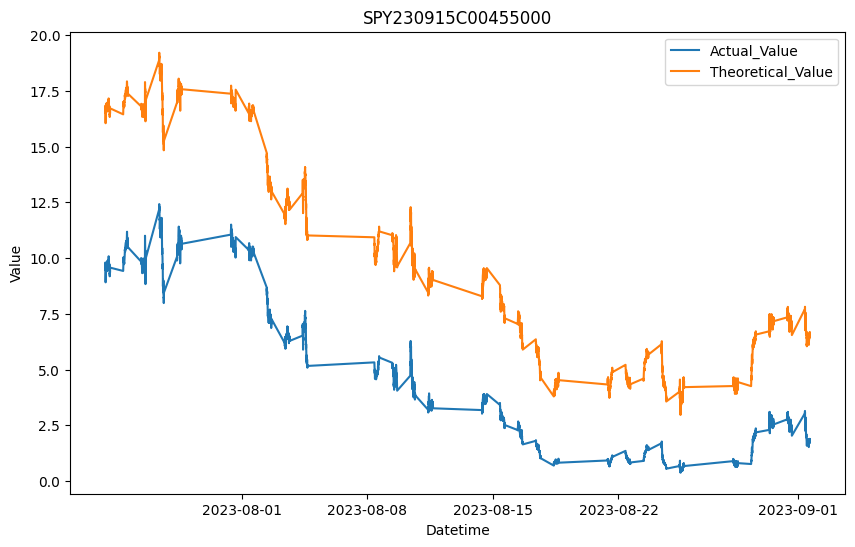

Cross Entropy: 1.0


In [49]:
new_df
# 將Datetime欄位轉換為日期時間型態
new_df['Datetime'] = pd.to_datetime(new_df['Datetime'])
# 設定圖形的大小
plt.figure(figsize=(10, 6))
# 繪製Actual_Value線
plt.plot(new_df['Datetime'], new_df['Actual_Value'], label='Actual_Value')
# 繪製Theoretical_Value線
plt.plot(new_df['Datetime'], new_df['Theoretical_Value'], label='Theoretical_Value')
# 添加圖例
plt.legend()
# 添加標題和軸標籤 
plt.title('SPY230915C00455000')
plt.xlabel('Datetime')
plt.ylabel('Value')

# 顯示圖形
plt.show()

# 將實際值和理論值轉換成概率分佈
actual_prob = new_df['Actual_Value'] / new_df['Actual_Value'].sum()
theoretical_prob = new_df['Theoretical_Value'] / new_df['Theoretical_Value'].sum()

# 計算交叉熵

p=[1/10 for i in range(10)] # list comprehension
cross_entropy = -np.sum(p * np.log10(p))
print("Cross Entropy:", cross_entropy)

In [56]:
(-1)**0.5


(6.123233995736766e-17+1j)

In [57]:
np.exp(1j * np.pi/4)

(0.7071067811865476+0.7071067811865476j)

In [58]:
(1+1j)**0.5

(1.0986841134678098+0.45508986056222733j)

In [61]:
2**0.25 * np.exp(1j * np.pi/8)

(1.0986841134678098+0.45508986056222733j)

In [64]:
100.5j == 1j  * 100.5

True

100.5j